# SGD on Diagonal Linear Networks

Replicating / investigating some results from the paper https://arxiv.org/pdf/2302.08982

In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [28]:
def hypentropy(alpha, beta):
    """
    The hyperbolic entropy function defined in equation (4).

    alpha, beta are ndarrays of shape (d,)
    """
    return 0.5 * np.sum(beta * np.arcsinh(beta / alpha**2) - np.sqrt(beta**2 + alpha**4) + alpha**2)

def grad_hypentropy(alpha, beta):
    return 0.5 * np.arcsinh(beta / alpha**2)

def bregman_hypentropy(alpha, x, y):
    return 0.5 * np.sum( np.sqrt(y**2 + alpha**4) - np.sqrt(x**2 + alpha**4) + x * (np.arcsinh(x / alpha**2) - np.arcsinh(y / alpha**2)) )

def grad_bregman_hypentropy(alpha, x, y):
    """gradient of D_ψ_α with respect to the first argument"""
    return grad_hypentropy(alpha, x) - grad_hypentropy(alpha, y)

In [34]:
def effective_initialization(alpha, updates):
    """
    The "effective initialization" term α_∞ from Theorem 1.

    alpha is the actual initialization
    updates should be an iterable containing the gradient updates,
     i.e. γ_k * ∇L(β_k) for each step k.
    """
    def q_aux_fn(x):
        return -0.5 * np.log((1 - x**2)**2)
    exp_term = np.exp( -np.sum([q_aux_fn(update) for update in updates]) )
    return np.sqrt(alpha**2 * exp_term)


def perturbation_term(alpha, updates):
    def q_plus(x):
        return -2*x - np.log((1 - x)**2)
    def q_minus(x):
        return 2*x - np.log((1 + x)**2)
    
    exp_plus = np.exp( -np.sum([q_plus(update) for update in updates]) )
    exp_minus = np.exp( -np.sum([q_minus(update) for update in updates]) )
    alpha_plus_squared = alpha**2 * exp_plus
    alpha_minus_squared = alpha**2 * exp_minus

    return 0.5 * (alpha_plus_squared - alpha_minus_squared)
    

### Graphs, checks for hypentropy function

In [9]:
def bregman_divergence_check(d, n):
    """compare bregman_hypentropy to the explicit defn of bregman divergence"""
    for _ in range(n):
        alpha, x, y = np.random.uniform(0,10, size=(d)), np.random.uniform(0,10, size=(d)), np.random.uniform(0,10, size=(d))
        breg_defn = hypentropy(alpha, x) - hypentropy(alpha, y) - np.sum(grad_hypentropy(alpha, y) * (x-y))
        assert np.allclose(breg_defn, bregman_hypentropy(alpha, x, y))
    print(f"bregman_hypentropy function passed all {n} tests.")

bregman_divergence_check(100, 1000)

bregman_hypentropy function passed all 1000 tests.


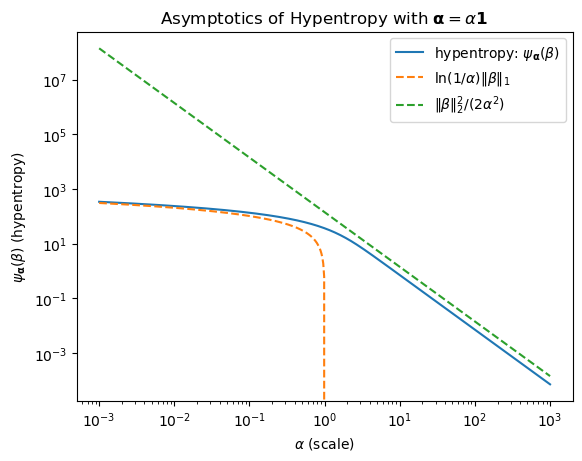

In [10]:
def asymptotic_small_scale(scale, beta):
    return np.log(1 / scale) * np.sum(np.abs(beta))

def asymptotic_large_scale(scale, beta):
    return np.sum(beta**2) / (2 * scale**2)

# Parameters
d = 10
scales = np.logspace(-3, 3, 500)  # scale values from 0.001 to 1000
beta = np.arange(d)

# Calculate hypentropy and asymptotic approximations for 1D
hyp = [hypentropy(scale * np.ones_like(beta), beta) for scale in scales]
asymp_small= [asymptotic_small_scale(scale, beta) for scale in scales]
asymp_large = [asymptotic_large_scale(scale, beta) for scale in scales]

# Plotting
plt.plot(scales, hyp, label='hypentropy: $\psi_{\mathbf{\\alpha}}(\\beta)$')
plt.plot(scales, asymp_small, label='$\ln(1/\\alpha) \|\\beta\|_1$', linestyle='--')
plt.plot(scales, asymp_large, label='$\|\\beta\|_2^2 / (2 \\alpha^2)$', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$α$ (scale)')
plt.ylabel('$\psi_{\mathbf{\\alpha}}(\\beta)$ (hypentropy)')
plt.title('Asymptotics of Hypentropy with $\mathbf{α} = α \mathbf{1}$')
plt.legend()
plt.show()


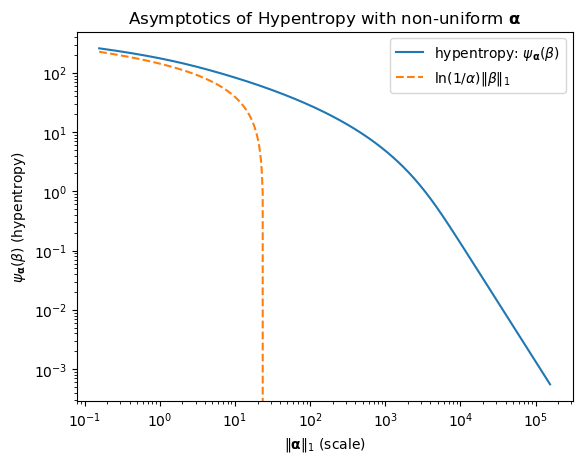

In [11]:
def weighted_small_scale(alpha, beta):
    return np.sum( np.log(1 / alpha) * np.abs(beta) )

def weighted_large_scale(alpha, beta):
    """NOT CORRECT RIGHT NOW. Also I don't think it's really important."""
    return np.sum(beta**2) / (2 * np.sum(alpha**2) )


# Calculate hypentropy and asymptotic approximations for 1D
# alphas = [scale * np.arange(1, 1+np.size(beta), step=100) for scale in scales]
alphas = [scale * np.logspace(-2, 2, np.size(beta)) for scale in scales]
hyp_weighted = [hypentropy(alpha, beta) for alpha in alphas]
asymp_small_weighted= [weighted_small_scale(alpha, beta) for alpha in alphas]
#asymp_large_weighted = [weighted_large_scale(alpha, beta) for alpha in alphas]  # not correct right now
weighted_scales = [np.sum(alpha) for alpha in alphas]  # actual measurement of "scale"

# Plotting
plt.plot(weighted_scales, hyp_weighted, label='hypentropy: $\psi_{\mathbf{\\alpha}}(\\beta)$')
plt.plot(weighted_scales, asymp_small_weighted, label='$\ln(1/\\alpha) \|\\beta\|_1$', linestyle='--')
#plt.plot(weighted_scales, asymp_large_weighted, label='$\|\\beta\|_2^2 / (2 \\alpha^2)$', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\|\mathbf{α}\|_1$ (scale)')
plt.ylabel('$\psi_{\mathbf{\\alpha}}(\\beta)$ (hypentropy)')
plt.title('Asymptotics of Hypentropy with non-uniform $\mathbf{α}$')
plt.legend()
plt.show()

## SGD results

In [16]:
def DLN(u, v, x):
    return np.inner(u*v, x)

def batch_loss(u, v, batch):
    return 0.5 * np.mean([(y - DLN(u,v,x))**2 for (x,y) in batch])

def sgd_update(u, v, lr, batch):
    """
    Updates u,v via SGD.
    Returns lr * ∇L(β_k), to be used for calculating α_∞ and β*_∞.

    (Note the difference between F and L in equation (2):
      F: R^(2d) -> R, while L: R^d -> R.)
    """
    X, Y = zip(*batch)
    errors = Y - np.sum(u * v * X, axis=1) 
    dF_du = -np.mean(errors[:, np.newaxis] * v * X, axis=0)
    dF_dv = -np.mean(errors[:, np.newaxis] * u * X, axis=0)
    
    u -= lr * dF_du
    v -= lr * dF_dv
    
    dL_dbeta = np.mean([(y - DLN(u,v,x)) * x for (x,y) in batch])
    return lr * dL_dbeta

def generate_sparse_regression_data(n, d, s, seed=None):
    """
    n (int): Number of samples
    d (int): Dimension of the input vectors
    s (int): Sparsity of beta_star
    seed (int, optional): Random seed for reproducibility

    Returns:
    X (ndarray): Generated input data of shape (n, d)
    y (ndarray): Generated output data of shape (n,)
    beta_star (ndarray): s-sparse vector of shape (d,)
    """
    if seed is not None:
        np.random.seed(seed)

    # Generate input data from standard normal distribution
    X = np.random.randn(n, d)

    # Generate a s-sparse vector beta_star
    beta_star = np.zeros(d)
    non_zero_indices = np.random.choice(d, s, replace=False)
    beta_star[non_zero_indices] = np.random.randn(s)

    # Compute the output data
    y = X @ beta_star

    return X, y, beta_star

In [32]:
seed = 123

max_epochs = 9000
n = 20   # Number of samples
d = 30   # Dimension of the input vectors
s = 3   # Number of non-zero entries in the sparse vector
a = 0.01  # Initialization scale

eps = 1e-8  # convergence threshold (not sure what to put)
bs = 1   # batch size

# train, test data
X_train, y_train, beta_star = generate_sparse_regression_data(n, d, s, seed)
X_test = np.random.randn(n, d)
y_test = X_test @ beta_star

# generate batches
train_batches = [list(zip(X_train[k:k+bs], y_train[k:k+bs])) for k in range(0, n, bs)]
assert len(train_batches) == n//bs

# initialization
alpha0 = a * np.ones(d)
u = alpha0
v = 0.1 * np.random.randn(d)

# quantities to track
updates = []
us, vs = [], []
train_losses = []
test_losses = []
n_epochs = 0

# run SGD to convergence
lr = 0.01
for i in range(max_epochs):
    # single epoch of SGD batch size 1
    for batch in train_batches:
        us.append(u)
        vs.append(v)
        updates.append(sgd_update(u, v, lr, batch))

    train_losses.append(batch_loss(u, v, zip(X_train, y_train)))
    test_losses.append(batch_loss(u, v, zip(X_test, y_test)))

    if train_losses[-1] < eps:
        print(f"\nConvergence reached after {i+1} epochs.")
        print(f"  Train loss: {train_losses[-1]}")
        print(f"  Test loss:  {test_losses[-1]}")
        break
    
    if (i+1) % (max_epochs // 10) == 0:
        print(f"epoch ({i+1})")
        print(f"  Train loss: {train_losses[-1]}")
        print(f"  Test loss:  {test_losses[-1]}")

epoch (900)
  Train loss: 0.00012490196524537589
  Test loss:  0.008742222450736564
epoch (1800)
  Train loss: 5.558111831830683e-06
  Test loss:  0.0070949122024134715
epoch (2700)
  Train loss: 4.3296998335509e-07
  Test loss:  0.006924276935826279
epoch (3600)
  Train loss: 4.1630183990553474e-08
  Test loss:  0.006883078524203226

Convergence reached after 4197 epochs.
  Train loss: 9.994568032695779e-09
  Test loss:  0.006873661087130713


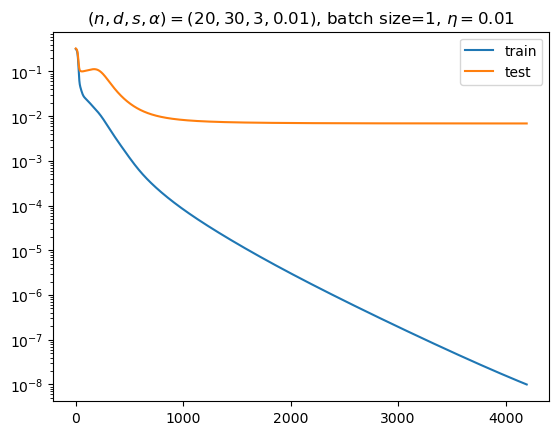

In [122]:
# plot test / train loss
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.legend()
plt.yscale('log')
plt.title(f"$(n,d,s,α)=({n}, {d}, {s}, {a})$, batch size={bs}, $\eta = {lr}$",)
plt.show()

In [121]:
def project_onto_S(beta, beta_star, X):
    """ Project beta onto the space S = beta_star + span(X)^perp. """
    P = X.T @ np.linalg.inv(X @ X.T) @ X  # Projection matrix onto span(X)
    projection = beta_star + (beta - beta_star) - P @ (beta - beta_star)
    return projection

def generate_perturbations(beta, dimension, n_samples=10000):
    """ Generate random perturbations of beta in its subspace. """
    perturbations = [beta + 0.01 * np.random.randn(dimension) for _ in range(n_samples)]
    return perturbations

def check_minimizer(f, beta, beta_star, X, dimension):
    # Project beta onto S
    beta_S = beta#project_onto_S(beta, beta_star, X)
    
    # Evaluate the function at beta_S
    value_at_beta_S = f(beta_S)
    
    # Generate perturbations around beta_S and evaluate them
    perturbations = generate_perturbations(beta_S, dimension)
    values_at_perturbations = [f(p) for p in perturbations]
    
    # Compare the function values
    num_higher = np.count_nonzero([value_at_beta_S <= val for val in values_at_perturbations])
    frac_higher = num_higher / len(values_at_perturbations)
    print("\nnum, frac ", num_higher, frac_higher)

    all_higher = all(value_at_beta_S <= val for val in values_at_perturbations)

    return all_higher, value_at_beta_S, values_at_perturbations


beta_final = us[-1] * vs[-1]
alpha_inf = effective_initialization(alpha0, updates)
beta_inf = perturbation_term(alpha0, updates)
def breg_hyp_at_alpha_beta_inf(beta):
    return bregman_hypentropy(alpha_inf, beta, beta_inf)
def hyp_at_init(beta):
    return hypentropy(alpha0, beta)

result, value_at_beta_S, values_at_perturbations = check_minimizer(breg_hyp_at_alpha_beta_inf, beta_final, beta_star, X_train, d)
#print("breg div of hyp at α_∞, β*_∞, beta_final is smaller than:", result)
print("Value at beta_S:", value_at_beta_S)
#print("Values at perturbations:", values_at_perturbations)

result, value_at_beta_S, values_at_perturbations = check_minimizer(hyp_at_init, beta_final, beta_star, X_train, d)
#print("hypentropy at α_0, beta_final is smaller than:", result)
print("Value at beta_S:", value_at_beta_S)


num, frac  10000 1.0
Value at beta_S: 0.420414431979205

num, frac  9999 0.9999
Value at beta_S: 0.41993081518692493
